# GARCH Stock Forecasting

In [73]:
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf


## Read Data

In [74]:
# Define the stock ticker, start date, and end date
ticker = "NVDA"  # Example: Disney
start = datetime.datetime(2023, 1, 1)
end = datetime.datetime(2024, 8, 25)

# Fetch the data using yfinance
stock_data = yf.download(ticker, start=start, end=end)

# Calculate returns (for example, daily returns)
stock_data['Return'] = stock_data['Adj Close'].pct_change()

# Drop NaN and infinite values
stock_data = stock_data.replace([np.inf, -np.inf], np.nan).dropna()


[*********************100%%**********************]  1 of 1 completed


## GARCH Modelling

In [75]:
# Fit a GARCH(1,1) model
model = arch_model(stock_data['Return'], vol='Garch', p=1, q=1)
model_fitted = model.fit(disp='off')

# Print model summary
print(model_fitted.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                826.981
Distribution:                  Normal   AIC:                          -1645.96
Method:            Maximum Likelihood   BIC:                          -1629.88
                                        No. Observations:                  412
Date:                Mon, Aug 26 2024   Df Residuals:                      411
Time:                        22:55:58   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.6023e-03  1.967e-03      3.357  7.891e-04 [2.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001065. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


## DIS Volatility

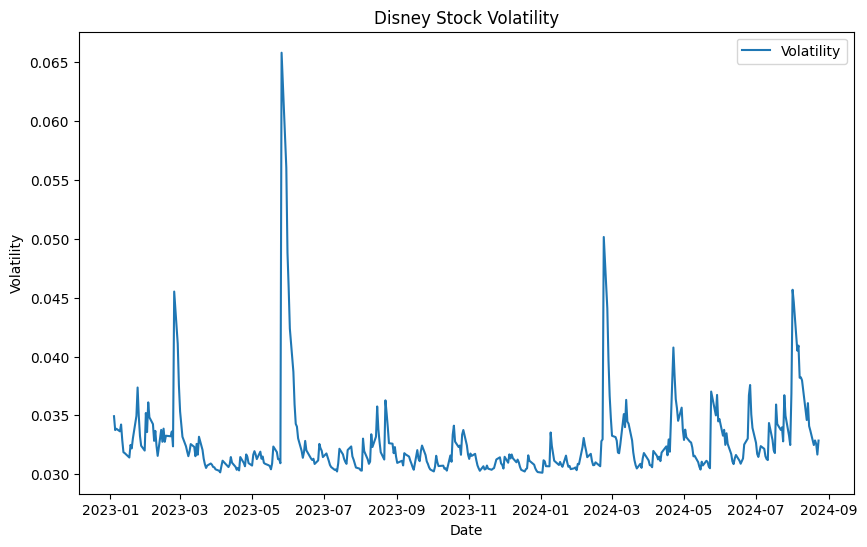

In [76]:
# Get the conditional volatility (standard deviation)
stock_data['Volatility'] = model_fitted.conditional_volatility

# Plot the volatility
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Volatility'], label='Volatility')
plt.title('Disney Stock Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


## PACF

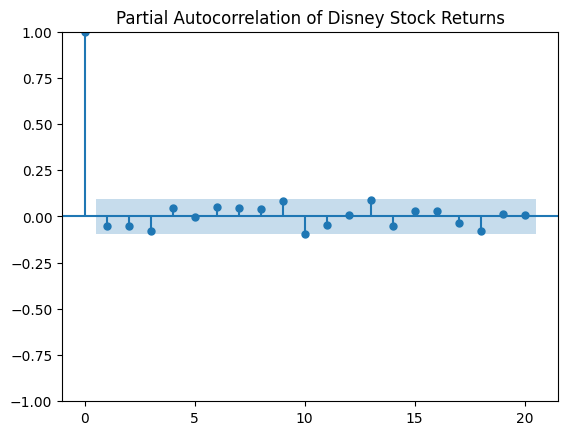

In [77]:
# Plot PACF
plot_pacf(stock_data['Return'], lags=20)
plt.title('Partial Autocorrelation of Disney Stock Returns')
plt.show()


## Rolling Forecast

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008722. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007623. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/L

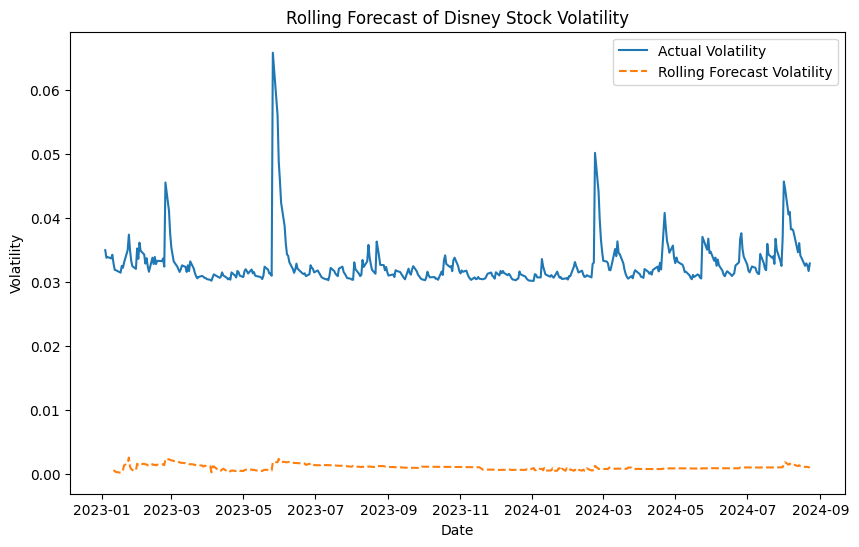

In [78]:
# Forecast future volatility for a rolling window
horizon = 5  # Forecasting 5 days ahead
rolling_forecasts = []

for i in range(horizon, len(stock_data)):
    model = arch_model(stock_data['Return'][:i], vol='Garch', p=1, q=1)
    model_fitted = model.fit(disp='off')
    forecast = model_fitted.forecast(horizon=1)
    rolling_forecasts.append(forecast.variance.values[-1, :][0])

# Align the forecasts with the original data
stock_data['Rolling_Volatility_Forecast'] = np.nan
stock_data.iloc[horizon:, stock_data.columns.get_loc('Rolling_Volatility_Forecast')] = rolling_forecasts

# Plot the rolling forecast against the actual volatility
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Volatility'], label='Actual Volatility')
plt.plot(stock_data['Rolling_Volatility_Forecast'], label='Rolling Forecast Volatility', linestyle='--')
plt.title('Rolling Forecast of Disney Stock Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


# How to use the model

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001065. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


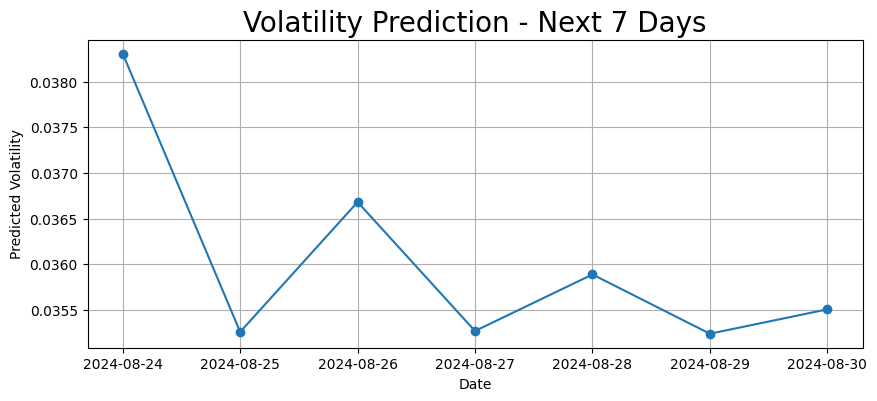

In [79]:
from datetime import timedelta
# Train data
train = stock_data['Return']

# GARCH Model
model = arch_model(train, vol='Garch', p=2, q=2)
model_fit = model.fit(disp='off')

# Volatility Prediction for the Next 7 Days
pred = model_fit.forecast(horizon=7)

# Generate future dates for the prediction horizon
future_dates = [train.index[-1] + timedelta(days=i) for i in range(1, 8)]

# Create a series with the predicted volatility values
pred_series = pd.Series(np.sqrt(pred.variance.values[-1, :]), index=future_dates)

# Plot the predicted volatility for the next 7 days
plt.figure(figsize=(10, 4))
plt.plot(pred_series, marker='o')
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Predicted Volatility')
plt.grid(True)
plt.show()
